# 1) Emotion Detection - Preparation

In [7]:
!pip install scikeras ####

# 1.1) Load the required libraries

In [8]:
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier #######
from tensorflow.keras.optimizers import Adam

In [9]:
from google.colab import drive
drive.mount('/content/drive') #####

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.2) Load the data from the files

In [10]:
# Base file path

def read_data(base_path):
    # Folder List
    folders = [
        'angry',
        'disgust',
        'fear',
        'happy',
        'neutral',
        'sad',
        'surprise'
    ]

    df=pd.DataFrame(columns=["images","labels"])

    # Iterate through the folders and collect images and labels
    i=0
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        if os.path.exists(folder_path):
            image_files = os.listdir(folder_path)
            image_files.sort()
            for image_file in image_files:
                image_path = os.path.join(folder_path, image_file)
                image = Image.open(image_path)#.convert('RGB')
                image = np.array(image)
                df.loc[i,"images"]=image
                df.loc[i,"labels"]=folder
                i+=1

    return df


In [11]:

train_path = '../content/drive/MyDrive/ComputerVision/Data/Emotions/train'########
test_path = '../content/drive/MyDrive/ComputerVision/Data/Emotions/validation' ########
train_df = read_data(train_path)
test_df=read_data(test_path)
df=pd.concat([train_df,test_df])

## 1.3) Plot the data

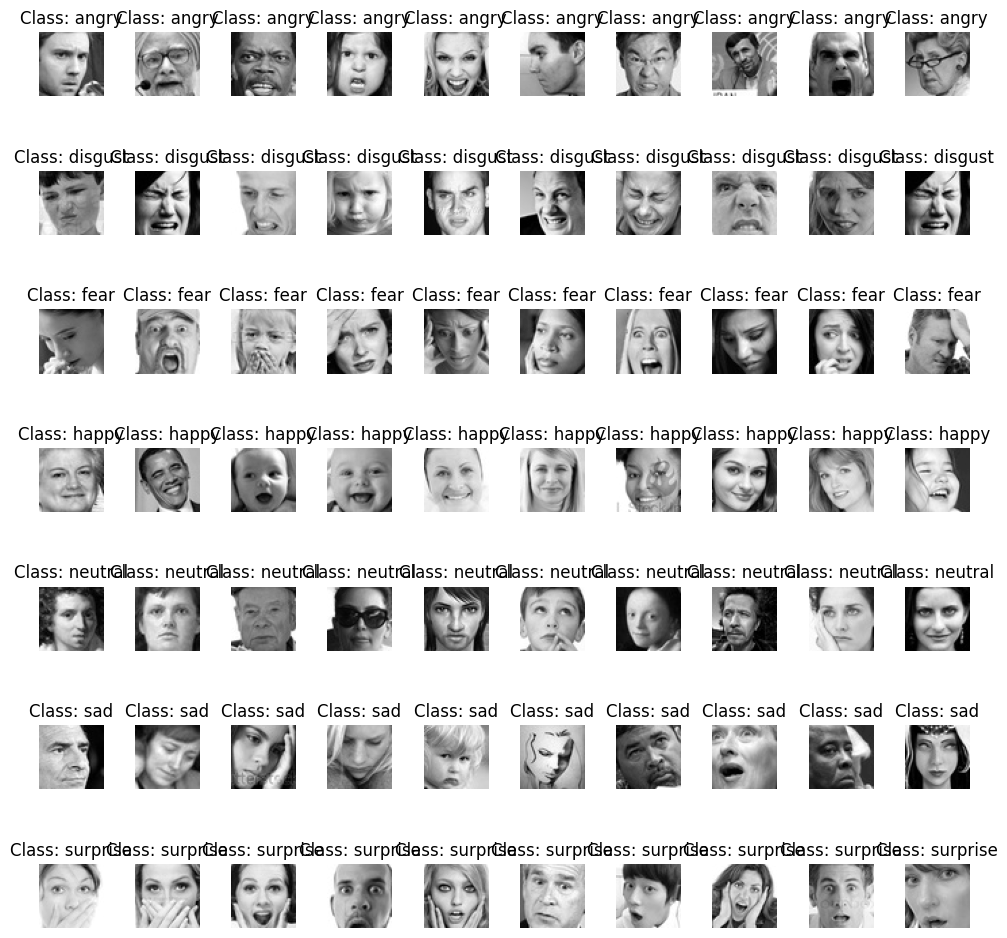

In [12]:
# Plot 10 pictures of each class

classes_to_plot = 7
images_per_class = 10
fig, axs = plt.subplots(classes_to_plot, images_per_class, figsize=(12, 12))

for i, label in enumerate(df['labels'].unique()):
    class_data = df[df['labels'] == label].head(images_per_class)
    for j, (_, row) in enumerate(class_data.iterrows()):
        ax = axs[i, j]
        ax.imshow(row['images'], cmap='gray')
        ax.axis('off')
        ax.set_title(f'Class: {label}')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

<Axes: xlabel='labels'>

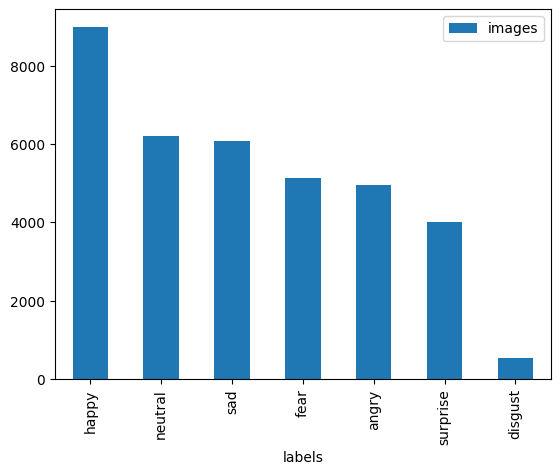

In [13]:
# Plot the number of images per label
df.groupby(["labels"]).count().sort_values("images",ascending=False).plot(kind="bar")

## 1.4) Split the dataset

In [14]:
df=df.sample(frac=1,random_state=0)
train,temp=train_test_split(df, test_size=0.3, random_state=0,shuffle=True,stratify=df["labels"])
val,test=train_test_split(temp, test_size=0.3, random_state=0,shuffle=True,stratify=temp["labels"])

## 1.5) Oversampling

In [15]:
oversample=RandomOverSampler(sampling_strategy="auto",random_state=0)
X_over, y_over = oversample.fit_resample( train[["images"]], train[["labels"]])

In [16]:
frames = [X_over, y_over]
train_oversampled = pd.concat(frames,axis=1)
train_oversampled =train_oversampled.sample(frac=1,random_state=0)


In [17]:
train_oversampled

,images,labels
19959,"[[51, 60, 45, 31, 40, 39, 43, 41, 50, 78, 40, ...",fear
15414,"[[206, 173, 172, 177, 182, 168, 217, 170, 148,...",fear
2293,"[[27, 28, 24, 18, 14, 13, 16, 22, 35, 50, 59, ...",sad
41704,"[[187, 174, 154, 159, 159, 156, 152, 157, 158,...",surprise
8242,"[[3, 1, 20, 103, 217, 132, 134, 154, 104, 148,...",angry
...,...,...
30403,"[[66, 35, 11, 16, 36, 53, 71, 88, 105, 121, 13...",disgust
21243,"[[254, 252, 169, 88, 81, 56, 96, 89, 78, 73, 9...",happy
42613,"[[158, 137, 153, 171, 195, 205, 196, 195, 181,...",surprise
43567,"[[149, 146, 146, 153, 162, 164, 164, 165, 158,...",surprise


<Axes: xlabel='labels'>

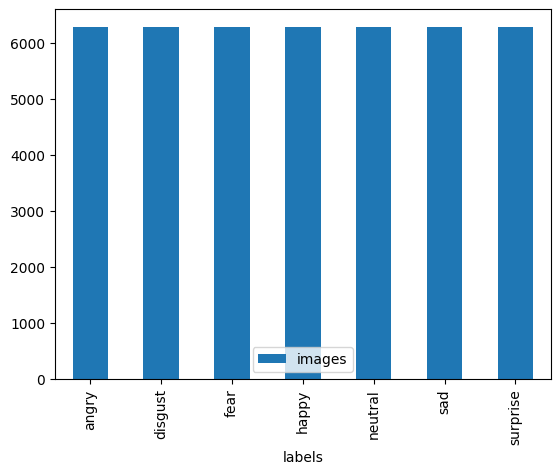

In [ ]:
 train_oversampled.groupby(["labels"]).count().sort_values("images",ascending=False).plot(kind="bar")

## 1.6) Data Augmentation

In [18]:
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)
validation_datagen = ImageDataGenerator(
       rescale=1./255
)

## 1.7) Conversion of the data into a suitable format

In [19]:
np.array(train_oversampled['labels'])

array(['fear', 'fear', 'sad', ..., 'surprise', 'surprise', 'angry'],
      dtype=object)

In [20]:
# Change "images" to NumPy ndarray
X_train = np.array(train_oversampled['images'].tolist())

# Change "labels" to NumPy ndarray
y_train = np.array(train_oversampled['labels'])

# Check the shape
print("Shape von X_train:", X_train.shape)
print("Shape von y_train:", y_train.shape)

Shape von X_train: (44044, 48, 48)
Shape von y_train: (44044,)


In [21]:
# Show Labels
train_oversampled['labels']

19959        fear
15414        fear
2293          sad
41704    surprise
8242        angry
           ...   
30403     disgust
21243       happy
42613    surprise
43567    surprise
2732        angry
Name: labels, Length: 44044, dtype: object

In [22]:
# Change Labels to numbers
mapping = {'angry':0,
    'disgust':1,
    'fear':2,
    'happy':3,
    'neutral':4,
    'sad':5,
    'surprise':6}
train_oversampled['labels'] = train_oversampled['labels'].map(mapping)
#X_train = np.array(train_oversampled['images'].tolist()
X_train_plot=np.expand_dims(X_train[10].reshape((1,) + X_train[1].shape), axis=-1)
X_train=np.stack(train_oversampled["images"].to_numpy())
#X_train = np.stack((X_train,) * 1, axis=-1)
X_train=np.expand_dims(X_train, axis=-1)
y_train=train_oversampled["labels"].values

In [23]:
X_val=np.stack(val["images"].to_numpy())
#X_train = np.stack((X_train,) * 1, axis=-1)
X_val=np.expand_dims(X_val, axis=-1)
val["labels"]=val["labels"].map(mapping)
y_val=val["labels"].values

In [24]:
X_test=np.stack(test["images"].to_numpy()) #####
X_test=np.expand_dims(X_test, axis=-1)
test["labels"]=test["labels"].map(mapping)
y_test=test["labels"].values

In [25]:
# Check shape
X_train_plot.shape

(1, 48, 48, 1)

In [ ]:
y_val

array([2, 0, 4, ..., 3, 3, 3])

In [26]:
# CHange to categorical
y_train_cat=to_categorical(y_train)
y_train_cat

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [27]:
y_val_cat=to_categorical(y_val)
y_val_cat

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [28]:
y_test_cat=to_categorical(y_test) ####
y_test_cat

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [29]:
batch_size = 8

train_iterator  = train_datagen.flow(X_train,  y_train_cat,
                                    batch_size=64)
validation_iterator = validation_datagen.flow(X_val,
                                              y_val_cat,
                                              batch_size=64) ####
test_iterator = test_datagen.flow(X_test,
                                              y_test_cat,
                                              batch_size=64)


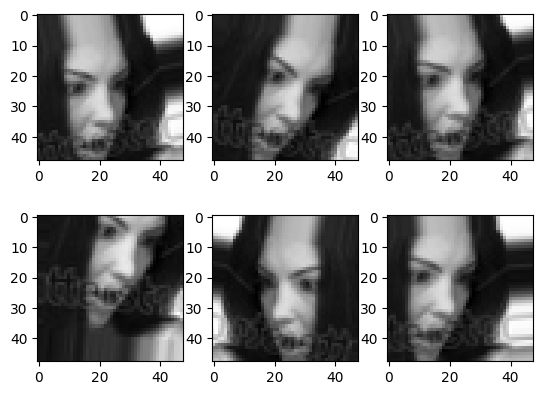

In [30]:
# Check Data Augmentation
def plotImages(x):
    i = 1
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(2,3,i)
        imgplot = plt.imshow(image.array_to_img(batch[0]),cmap='gray')
        i += 1
        if i % 7 == 0:
            break
    plt.show()

plotImages(X_train_plot)


# 2) Emotion Detection - Simple model

## 2.1) Try a very simple model first

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(48,48,1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(7,  activation=tf.nn.softmax)
])

In [32]:
metric_accuracy = tf.keras.metrics.CategoricalAccuracy('categorical_accuracy')
metric_precision = tf.keras.metrics.Precision()
metric_recall = tf.keras.metrics.Recall()

loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=loss,
              metrics=[metric_accuracy])

In [33]:
history = model.fit(train_iterator, validation_data = validation_iterator,
                    epochs=100, batch_size=128)

Epoch 1/100
689/689 [==============================] - 28s 31ms/step - loss: 1.9453 - categorical_accuracy: 0.1653 - val_loss: 1.9481 - val_categorical_accuracy: 0.1587
Epoch 2/100
689/689 [==============================] - 21s 30ms/step - loss: 1.9303 - categorical_accuracy: 0.1844 - val_loss: 2.0015 - val_categorical_accuracy: 0.0845
Epoch 3/100
689/689 [==============================] - 21s 30ms/step - loss: 1.9212 - categorical_accuracy: 0.1921 - val_loss: 1.9440 - val_categorical_accuracy: 0.1426
Epoch 4/100
689/689 [==============================] - 21s 30ms/step - loss: 1.9136 - categorical_accuracy: 0.1998 - val_loss: 1.8964 - val_categorical_accuracy: 0.1904
Epoch 5/100
689/689 [==============================] - 21s 31ms/step - loss: 1.9104 - categorical_accuracy: 0.2016 - val_loss: 1.9255 - val_categorical_accuracy: 0.1346
Epoch 6/100
689/689 [==============================] - 21s 30ms/step - loss: 1.9048 - categorical_accuracy: 0.2070 - val_loss: 1.8758 - val_categorical_acc

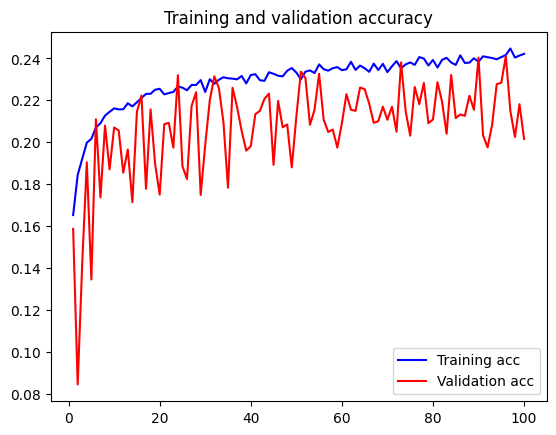

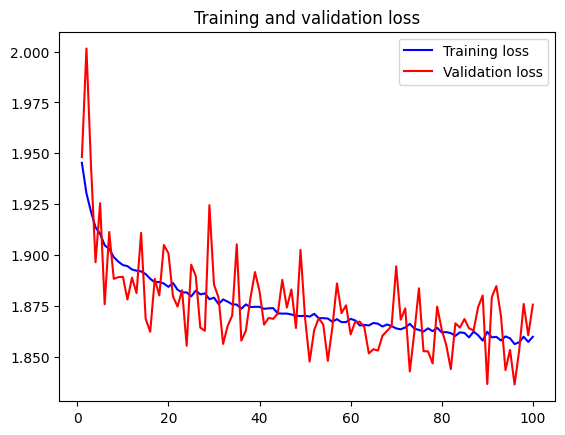

In [34]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [35]:
model.evaluate(X_val, y_val_cat)

236/236 [==============================] - 1s 2ms/step - loss: 609.7664 - categorical_accuracy: 0.1137


[609.7664184570312, 0.11372080445289612]

In [ ]:
# Save the model
model.save('../content/drive/MyDrive/ComputerVision/Models/emotion_detection_model_v11.h5')

In [46]:
model_pred=tf.keras.models.load_model('../content/drive/MyDrive/ComputerVision/Models/emotion_detection_model_v11.h5') ###

101/101 [==============================] - 0s 1ms/step


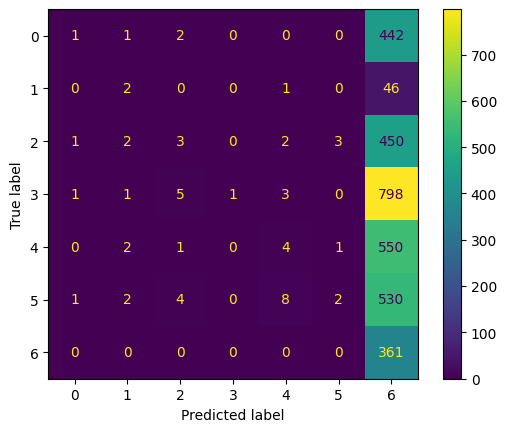

Accuracy: 0.11575363664500155
Recall: [0.00224215 0.04081633 0.00650759 0.00123609 0.00716846 0.00365631
 1.        ]
Precision: [0.25       0.2        0.2        1.         0.22222222 0.33333333
 0.11362921]
Precision: [0.00444444 0.06779661 0.01260504 0.00246914 0.01388889 0.00723327
 0.2040701 ]


In [47]:
predicted=np.argmax(model_pred.predict(X_test), axis=1) ####
predicted

remapping = {0:'angry',
    1:'disgust',
    2:'fear',
    3:'happy',
    4:'neutral',
    5:'sad',
    6:'surprise'}
predicted_remapped=pd.DataFrame(predicted)[0].map(remapping)
predicted_remapped

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,accuracy_score, recall_score, precision_score,f1_score

cm=confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ["negative[0]", "Positive[1]"])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, predicted,average=None)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, predicted,average=None)
print("Precision:", precision)

f1 = f1_score(y_test, predicted,average=None)
print("Precision:", f1)


## 2.2) Grid search


Das dauert ewig.

In [38]:

def create_model(activation='relu', learning_rate=0.01, num_neurons1=64, num_neurons2=64, num_neurons3=64):
    model = Sequential()
    model.add(Flatten(input_shape=(48,48,1))),
    model.add(Dense(num_neurons1, activation=activation)),
    model.add(Dense(num_neurons2, activation=activation)),
    model.add(Dense(num_neurons3, activation=activation))
    model.add(Dense(7, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

# Using a Keras Classifier Model for this task
model = KerasClassifier(model=create_model,activation='relu',  verbose=1, learning_rate=0.001,num_neurons1=64,num_neurons2=32, num_neurons3=16)

# Define the hyperparameters
param_grid = {
    'activation': ['relu', 'sigmoid', 'tanh'],
    'learning_rate': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'num_neurons1': [64, 128, 256, 512],
    'num_neurons2': [32, 64, 128, 256],
    'num_neurons3': [16, 32, 64, 128]

}
# Do the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy',error_score='raise')
grid_result = grid.fit(X_train, y_train_cat)


best_params = grid_result.best_params_

# Show the best hyperparameters
print("Beste Hyperparameter:", grid_result.best_params_)


Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
817/918 [=========================>....] - ETA: 0s - loss: 3.0101 - accuracy: 0.1416

KeyboardInterrupt: ignored

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(48,48,1)),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(7,  activation=tf.nn.softmax)
])

NameError: ignored

In [ ]:
metric_accuracy = tf.keras.metrics.CategoricalAccuracy('categorical_accuracy')
metric_precision = tf.keras.metrics.Precision()
metric_recall = tf.keras.metrics.Recall()

loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=loss,
              metrics=[metric_accuracy])

In [ ]:
history = model.fit(train_iterator, validation_data = validation_iterator,
                    epochs=100, batch_size=128)

NameError: ignored

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
# Modell speichern
model.save('emotion_detection_model_v12.h5')

## 2.3) Use of Batch and Dropout Layers

In [ ]:
model = tf.keras.Sequential([
    Flatten(input_shape=(48, 48, 1)),
    Dense(1024, activation=tf.nn.relu),
    BatchNormalization(),  # Batch Normalization
    Dense(512, activation=tf.nn.relu),
    Dropout(0.5),  # Dropout
    Dense(256, activation=tf.nn.relu),
    BatchNormalization(),  # Batch Normalization
    Dense(128, activation=tf.nn.relu),
    Dense(7, activation=tf.nn.softmax)
])


metric_accuracy = tf.keras.metrics.CategoricalAccuracy('categorical_accuracy')
metric_precision = tf.keras.metrics.Precision()
metric_recall = tf.keras.metrics.Recall()
loss = tf.keras.losses.CategoricalCrossentropy()


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=loss,
              metrics=[metric_accuracy])


history = model.fit(train_iterator, validation_data = validation_iterator,
                    epochs=100, batch_size=128)

Epoch 1/100
689/689 [==============================] - 100s 140ms/step - loss: 2.0564 - categorical_accuracy: 0.1756 - val_loss: 1.9566 - val_categorical_accuracy: 0.1603
Epoch 2/100
689/689 [==============================] - 82s 119ms/step - loss: 1.9572 - categorical_accuracy: 0.1901 - val_loss: 1.9013 - val_categorical_accuracy: 0.2054
Epoch 3/100
689/689 [==============================] - 97s 141ms/step - loss: 1.9380 - categorical_accuracy: 0.1939 - val_loss: 1.8804 - val_categorical_accuracy: 0.2066
Epoch 4/100
689/689 [==============================] - 93s 136ms/step - loss: 1.9245 - categorical_accuracy: 0.2013 - val_loss: 1.8528 - val_categorical_accuracy: 0.2454
Epoch 5/100
689/689 [==============================] - 86s 124ms/step - loss: 1.9168 - categorical_accuracy: 0.2065 - val_loss: 1.8750 - val_categorical_accuracy: 0.2162
Epoch 6/100
689/689 [==============================] - 100s 145ms/step - loss: 1.9095 - categorical_accuracy: 0.2097 - val_loss: 1.8704 - val_categor

Epoch 49/100
689/689 [==============================] - 48s 70ms/step - loss: 1.8132 - categorical_accuracy: 0.2738 - val_loss: 1.7948 - val_categorical_accuracy: 0.2739
Epoch 50/100
689/689 [==============================] - 51s 74ms/step - loss: 1.8117 - categorical_accuracy: 0.2756 - val_loss: 1.7927 - val_categorical_accuracy: 0.2706
Epoch 51/100
689/689 [==============================] - 46s 66ms/step - loss: 1.8059 - categorical_accuracy: 0.2778 - val_loss: 1.8241 - val_categorical_accuracy: 0.2622
Epoch 52/100
689/689 [==============================] - 46s 66ms/step - loss: 1.8081 - categorical_accuracy: 0.2811 - val_loss: 1.7883 - val_categorical_accuracy: 0.2769
Epoch 53/100
689/689 [==============================] - 47s 68ms/step - loss: 1.8055 - categorical_accuracy: 0.2824 - val_loss: 1.7930 - val_categorical_accuracy: 0.2807
Epoch 54/100
689/689 [==============================] - 50s 73ms/step - loss: 1.8088 - categorical_accuracy: 0.2792 - val_loss: 1.8078 - val_categoric

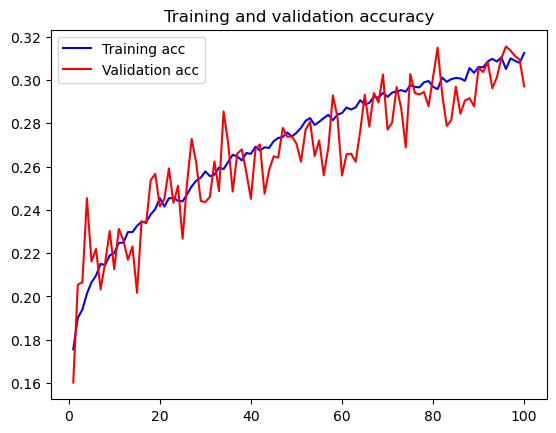

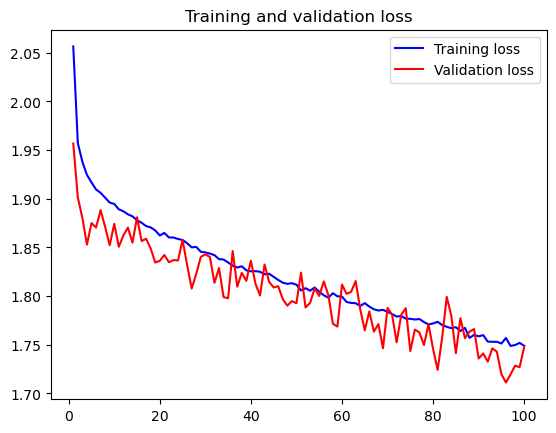

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Modell speichern
model.save('../content/drive/MyDrive/ComputerVision/Models/emotion_detection_model_v13.h5')

In [ ]:
model.evaluate(X_val, y_val_cat)

In [ ]:
predicted=np.argmax(model.predict(X_test), axis=1)
predicted

remapping = {0:'angry',
    1:'disgust',
    2:'fear',
    3:'happy',
    4:'neutral',
    5:'sad',
    6:'surprise'}
predicted_remapped=pd.DataFrame(predicted)[0].map(remapping)
predicted_remapped

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,accuracy_score, recall_score, precision_score,f1_score

cm=confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ["negative[0]", "Positive[1]"])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, predicted,average=None)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, predicted,average=None)
print("Precision:", precision)

f1 = f1_score(y_test, predicted,average=None)
print("Precision:", f1)